In [16]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.transforms import functional as F
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model = fasterrcnn_mobilenet_v3_large_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, 5)
model.load_state_dict(torch.load('tajwid_detector.pth', map_location=device))
model.to(device)
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [18]:
def predict_and_show(img_path, threshold=0.4):
    img = Image.open(img_path).convert("RGB")
    img_tensor = F.to_tensor(img).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(img_tensor)[0]

    label_map = {1: "idzhar", 2: "ikhfa", 3: "idgham", 4: "iklab"}
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    for box, label, score in zip(pred['boxes'], pred['labels'], pred['scores']):
        if score > threshold:
            x1, y1, x2, y2 = map(int, box.tolist())
            cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(img_cv, f"{label_map[label.item()]} {score:.2f}", (x1, y1-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)

    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


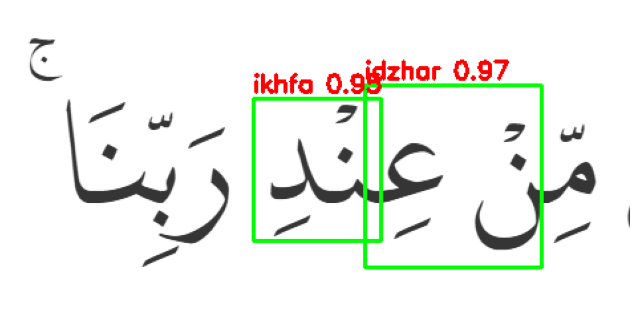

In [21]:
predict_and_show('data_test/large_test.png')
